##Introduction

In this example we follow [An Introduction to the Conjugate Gradient Method Without the Agonizing Pain](http://www.cs.cmu.edu/~quake-papers/painless-conjugate-gradient.pdf) and demonstrate few concepts in Python. I shamelessly quote the original document in few places. References to equations and figures are given in terms of the original document.

From [https://ilyakuzovkin.com/ml-ai-rl-cs/the-concept-of-conjugate-gradient-descent-in-python/](https://ilyakuzovkin.com/ml-ai-rl-cs/the-concept-of-conjugate-gradient-descent-in-python/)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import itertools

A 2D example we will work with:

In [2]:
A = np.matrix([[3.0, 2.0], [2.0, 6.0]])
b = np.matrix([[2.0], [-8.0]])  # we will use the convention that a vector is a column vector
c = 0.0

The quadratic form:
$$f(x) = \frac{1}{2}x^\text{T}Ax-b^\text{T}x+c$$  
$$f'(x) = Ax - b$$
$$Ax - b = 0$$

In [3]:
def f(x, A, b, c):
    return ((0.5 * x.T * A * x - b.T * x + c)[0,0])

Evaluate the function on a small grid and draw it:

In [4]:
def bowl(A, b, c):
    fig = plt.figure(figsize=(10,8))
    qf = fig.add_subplot(projection='3d')
    size = 20
    x1 = list(np.linspace(-6, 6, size))
    x2 = list(np.linspace(-6, 6, size))
    x1, x2 = np.meshgrid(x1, x2)
    zs = np.zeros((size, size))
    for i in range(size):
        for j in range(size):
            x = np.matrix([[x1[i,j]], [x2[i,j]]])
            zs[i,j] = f(x, A, b, c)
    qf.plot_surface(x1, x2, zs, rstride=1, cstride=1, cmap=plt.colormaps['coolwarm'], linewidth=0)
    fig.show()
    return x1, x2, zs

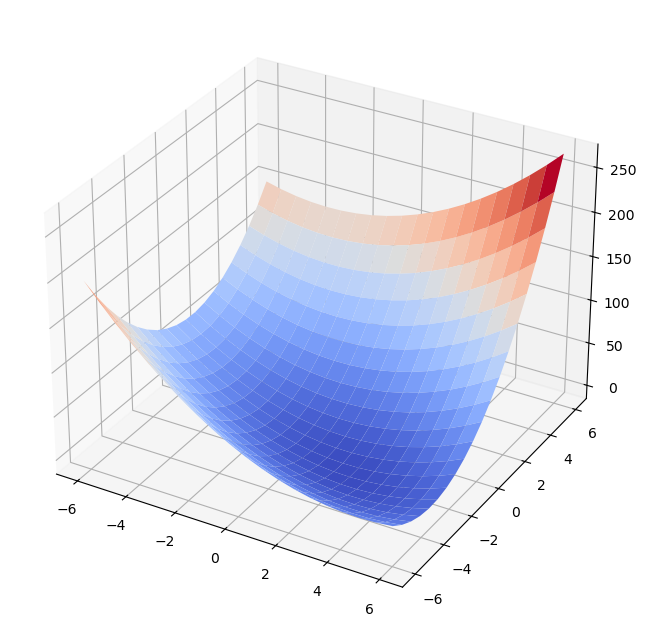

In [5]:
x1, x2, zs = bowl(A, b, c)

In [6]:
def contoursteps(x1, x2, zs, steps=None):
    fig = plt.figure(figsize=(6,6))
    cp = plt.contour(x1, x2, zs, 10)
    plt.clabel(cp, inline=1, fontsize=10)
    if steps is not None:
        steps = np.matrix(steps)
        plt.plot(steps[:,0], steps[:,1], '-o')
    fig.show()

Contour plot of the same quadratic form:

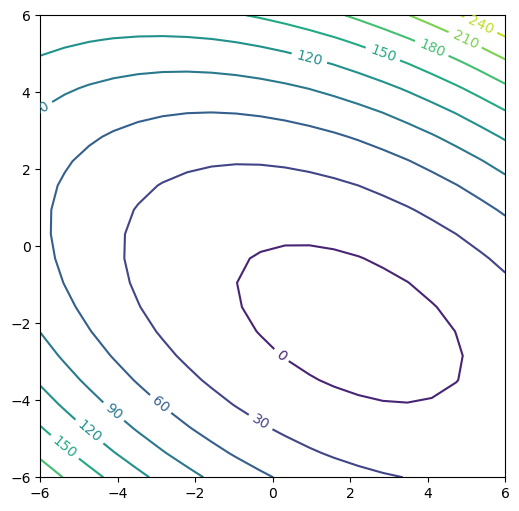

In [7]:
contoursteps(x1, x2, zs)

##The Method of Steepest Descent

The algorithm is implemented following (with slight changes) the psudocode from the Appendix B1 of the tutorial.

In [8]:
x = np.matrix([[-2.0],[-2.0]])
steps = [(-2.0, -2.0)]
i = 0
imax = 10
eps = 0.01
r = b - (A * x)
delta = (r.T * r)[0,0]
delta0 = delta
while i < imax and delta > eps**2 * delta0:
    alpha = delta / ((r.T * (A * r))[0,0])
    x = x + alpha * r
    steps.append((x[0,0], x[1,0]))  # store steps for future drawing
    r = b - A * x
    delta = (r.T * r)[0,0]
    i += 1

Here we can follow its steps:

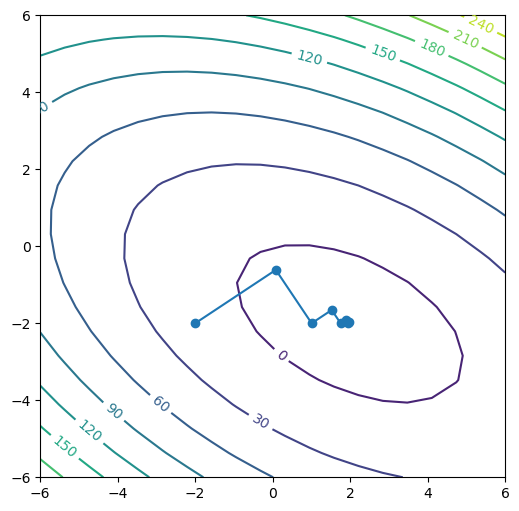

In [9]:
contoursteps(x1, x2, zs, steps)

####Let us have a look at one iteration

We visualize various thingies what play a role in there. It will help to gain the intuition of how it goes. First we initialize the starting point and few parameters:

In [10]:
x = np.matrix([[-2.0],[-2.0]])
steps = [(-2.0, -2.0)]
i = 0
imax = 10
eps = 0.01

The first object to look at is *residual* denoted by `r` in the code, let's see what exactly it stands for:

b: [[ 2.]
 [-8.]]
A: [[3. 2.]
 [2. 6.]]
x: [[-2.]
 [-2.]]
r: [[12.]
 [ 8.]]


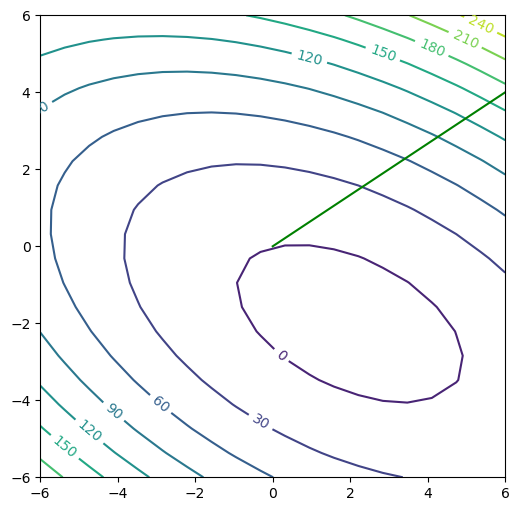

In [11]:
print("b:", b)
print("A:", A)
print("x:", x)
r = b - A * x
print("r:", r)
contoursteps(x1, x2, zs, None)
plt.plot([0, r[0, 0] * 0.5], [0, r[1, 0] * 0.5], 'g')
plt.show()

Observe now that *residual* actually means *direction of steepest descent*. The vector also has a magnitude, as you can see, but since it does not directly provide any useful information (other that some notion of how far away are we from the desired solution) we will not dig into it.

In [12]:
print('||r||^2 =', np.linalg.norm(r)**2)
delta = (r.T * r) [0,0]
print('r.T * r = ',  delta)
delta0 = delta

||r||^2 = 207.99999999999997
r.T * r =  208.0


In [13]:
#while i < imax and delta > eps**2 * delta0:

We now have the direction, the next question is *how far along that direction we need to go?*. The procedure to answer that is called *line search* and its task to take the direction and find the minimal point of the parabola formed by this aline and the quadratic bowl. We need to estimate `alpha` $\in[0,1]$ which will tell how far along the line we should move.
The equation to get `alpha` in our code is:  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;   `alpha = float(delta / (r.T * (A * r)))`,  
which corresponds to  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;   $\alpha = \frac{r^\text{T}_{(0)}r_0}{r^\text{T}_{(0)}Ar_0}$
in the tutorial. Let me repeat the derivation from the tutorial to see why this will give the `alpha` we want (please refer to Figure 6 of the tutorial to agree with the initial premise $r^\text{T}_{(1)}r_0 = 0$ ):  
$$r^\text{T}_{(1)}r_0 = 0$$  
$$(b - Ax_{(1)})^\text{T}r_0 = 0$$  
$$(b - A(x_{(0)} + \alpha r_{(0)}))^\text{T}r_0 = 0$$  
$$(b - Ax_{(0)})^\text{T}r_{(0)} - \alpha(Ar_{(0)})^\text{T}r_0 = 0$$  
$$(b - Ax_{(0)})^\text{T}r_{(0)} = \alpha(Ar_{(0)})^\text{T}r_0$$  
$$r_{0}^\text{T}r_{(0)} = \alpha r_0^\text{T}(Ar_{(0)})$$  
$$\alpha = \frac{r^\text{T}_{(0)}r_0}{r^\text{T}_{(0)}Ar_0}$$  

In [14]:
alpha = delta / ((r.T * A * r)[0,0])

Now we know how far to got along `r` and we update our solution `x`:

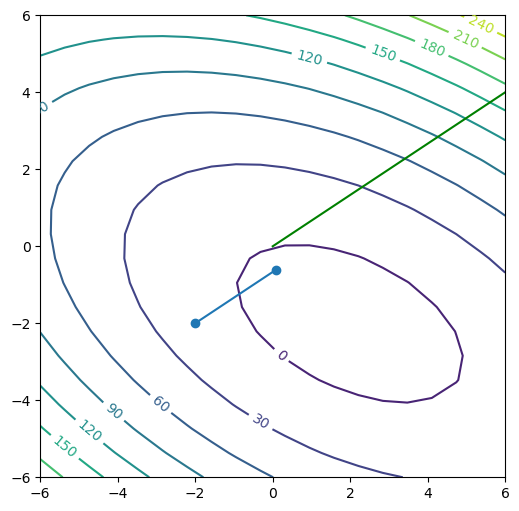

In [15]:
x = x + alpha * r
contoursteps(x1, x2, zs, [(-2, -2), (x[0, 0], x[1, 0])])
plt.plot([0, r[0, 0] * 0.5], [0, r[1, 0] * 0.5], 'g')
plt.show()

And now the loop repeats: we are in some location, we compute residual, get the direction:

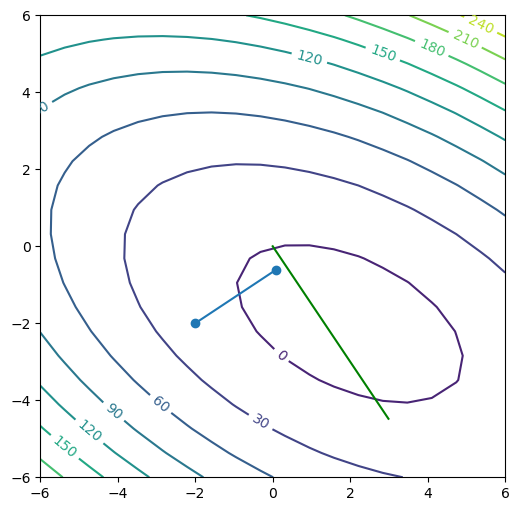

In [16]:
r = b - A * x
contoursteps(x1, x2, zs, [(-2, -2), (x[0, 0], x[1, 0])])
plt.plot([0, r[0, 0]], [0, r[1, 0]], 'g')

Update delta, and the iteration counter and we are ready to perform next *line search* and make the next step

In [17]:
delta = (r.T * r)[0,0]
i += 1

####Gradient descent

It might we interesting for you to compare *steepest descect* to what we usually refer to as *gradient descent* where instead of performing *line search* we fix `alpha` (*learning rate*) to some fixed parameter:

In [18]:
x = np.matrix([[-2.0],[-2.0]])
steps = [(-2.0, -2.0)]
i = 0
imax = 10000
eps = 0.01
alpha = 0.12  # play with this value to see how it affects the optimization process, try 0.05, 0.27 and 0.3
r = b - A * x
delta = (r.T * r)[0,0]
delta0 = delta
while i < imax and delta > eps**2 * delta0:
    x = x + alpha * r
    steps.append((x[0,0], x[1,0]))  # store steps for future drawing
    r = b - A * x
    delta = r.T * r
    i += 1

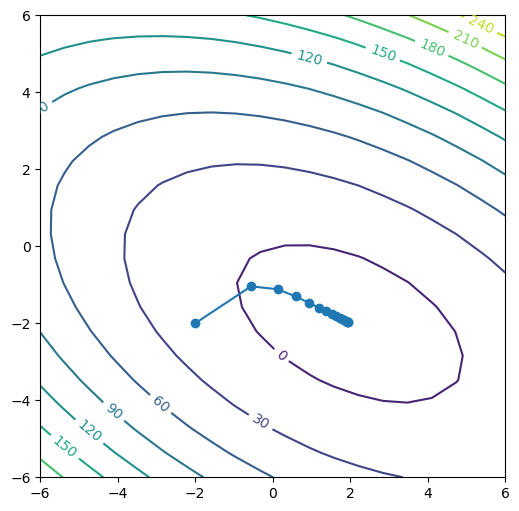

In [19]:
contoursteps(x1, x2, zs, steps)

Change the `alpha` parameter to see what happens when your learning rate it too low or too high.

##The Method of Conjudate Directions

As you have seen in the steepest descent method the algorihtm makes steps in same direction several times. Here's an idea: let's pick a set of orthoginal *search directions* so that if we take exactly one step of right length in each of those directions we will reach the minimum.

###Conjugacy

First we introduce the notion of *A-orthogonal* vectors, where A is the matrix with coefficients from our orignal equation $Ax = b$.  
Take round quadratic bowl

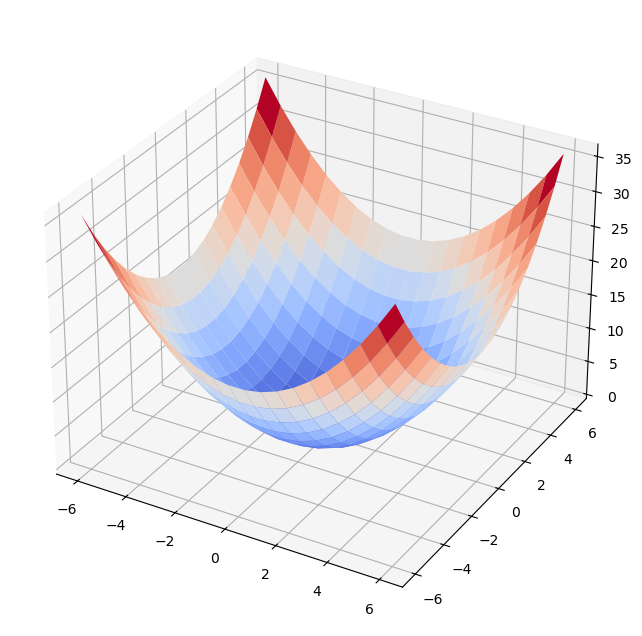

In [20]:
Around = np.matrix([[1, 0],[0, 1]])
bround = np.matrix([[0],[0]])
cround = 0
x1, x2, zs = bowl(Around, bround, cround)

Now take tow orhogonal vectors and draw them:

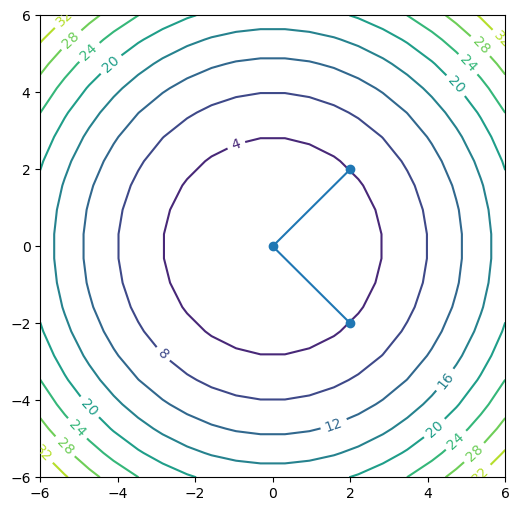

In [21]:
va = np.matrix([[2],[2]])
vb = np.matrix([[2],[-2]])
contoursteps(x1, x2, zs, [(va[0,0],va[1,0]),(0,0),(vb[0,0],vb[1,0])])

Now instread of identity matrix take a matrix that has Y axis scaled up 2 times.

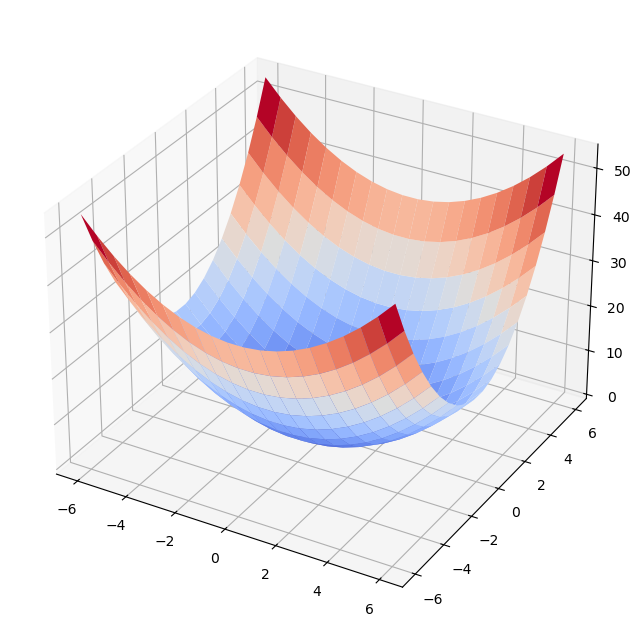

In [22]:
Ascaled = np.matrix([[1, 0],[0, 2]])
bscaled = np.matrix([[0],[0]])
cscaled = 0
x1, x2, zs = bowl(Ascaled, bscaled, cscaled)

To counter the scale of the matrix we scale X components of the vectors 2 times and draw them:

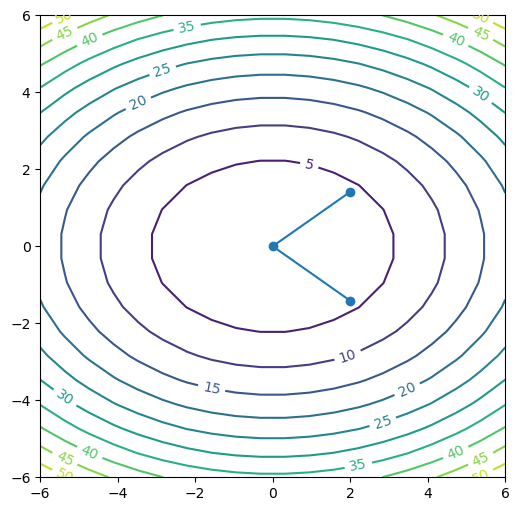

In [23]:
va = np.matrix([[2],[np.sqrt(2)]])
vb = np.matrix([[2],[-np.sqrt(2)]])
contoursteps(x1, x2, zs, [(va[0,0],va[1,0]),(0,0),(vb[0,0],vb[1,0])])

As you can see those vectors are not orthogonal:

In [24]:
(va.T * vb)[0,0]

np.float64(1.9999999999999998)

but they are $A$-othogonal under the matrix `Ascaled`:

In [25]:
(va.T * Ascaled * vb)[0,0]

np.float64(-5.468646926129539e-16)

Vectors $a$ and $b$ are $A$-orthogonal or *conjugate* iff $$a^\text{T}Ab = 0$$  
The intuition is to imagine that if you stretch the contour plot so that the contours are circles and two vectors become orthogonal then they are $A$-orthogonal.  
Ok, well, why would we care about those? Imagine that you need to find solution in non-distorted circular 2D bowl:

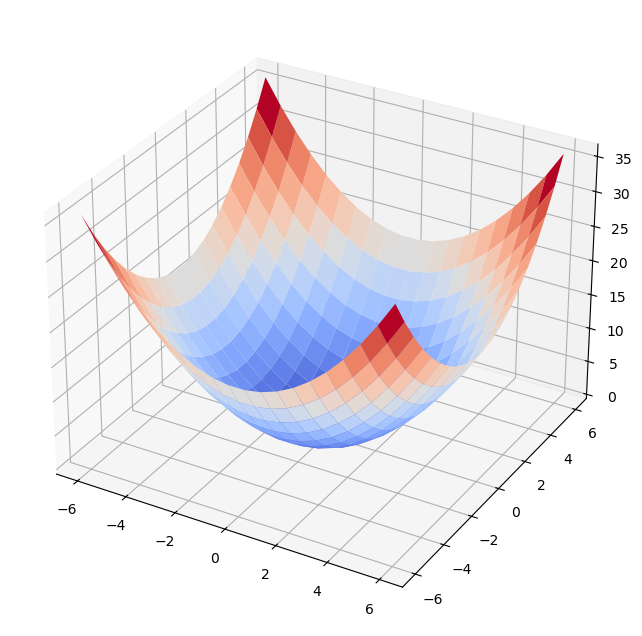

In [26]:
Around = np.matrix([[1, 0],[0, 1]])
bround = np.matrix([[0],[0]])
cround = 0
x1, x2, zs = bowl(Around, bround, cround)

then you could achieve your solution in two steps using usual steepest descent:

In [27]:
x = np.matrix([[-2.0],[-2.0]])
steps = [(-2.0, -2.0)]
i = 0
imax = 10
eps = 0.01
r = bround - np.matrix([[1, 0],[0, 0]]) * x  # replaced Around with this to force residual to be parallel to X axis
delta = (r.T * r)[0,0]
delta0 = delta
while i < imax and delta > eps**2 * delta0:
    alpha = delta / (r.T * (Around * r))[0,0]
    x = x + alpha * r
    steps.append((x[0,0], x[1,0]))  # store steps for future drawing
    r = bround - Around * x
    delta = (r.T * r)[0,0]
    i += 1

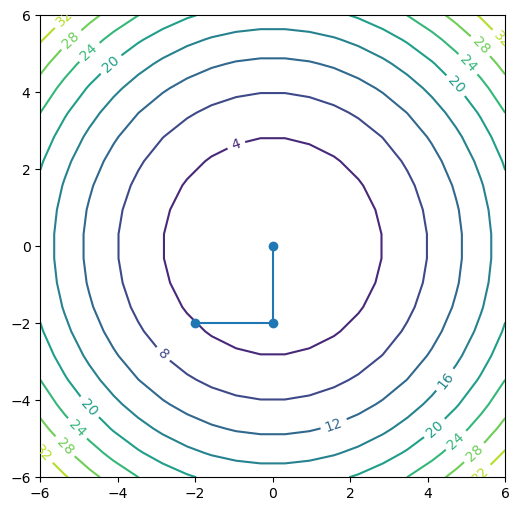

In [28]:
contoursteps(x1, x2, zs, steps)

That would be cool, wouldn't it? Unfortunately optimization problems do not always have circular bowl error surface. So if we use conjugate directions instead of orthogonal ones then it is as-if we are solving our problem on circular bowl surface. All that is needed now is a set of conjugate ($A$-othogonal) directions, fortunately we can find those using *conjugate Gram-Schmidt process*.

###Gram-Schmidt Conjugation

We will need $n$ conjugate directions. First we take $n$ linearly independent vectors. For example *residuals* we used in the steepest descent will do nicely, because we selected each next residual to be orthogonal to the previous search directions (Equation 39). Right now I will only mention that Gram-Schmidt process is the method we will use and later you will see how it works and what it does.

##The Method of Conjugate Gradients

Let me generate the original error surface again.

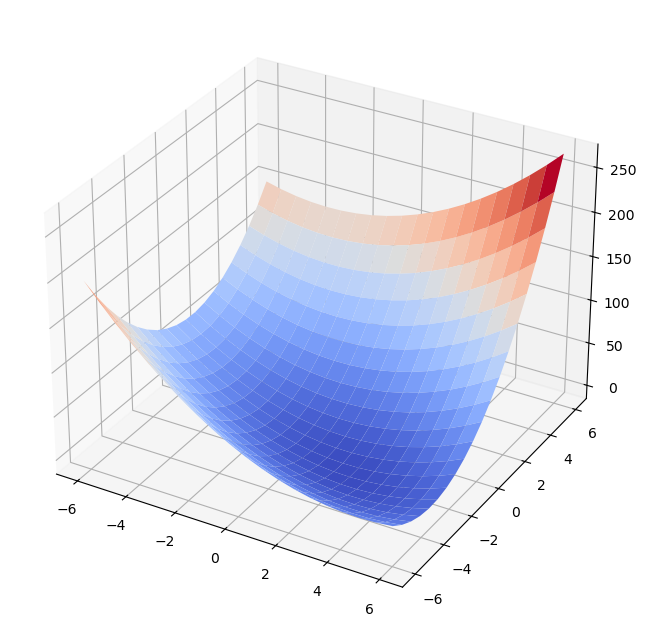

In [29]:
x1, x2, zs = bowl(A, b, c)

And follow the pseudocode in B2 to implement CG method.

In [30]:
x = np.matrix([[-2.0],[-2.0]])
steps = [(-2.0, -2.0)]
i = 0
imax = 10
eps = 0.01
r = b - A * x
d = r
deltanew = (r.T * r)[0,0]
delta0 = deltanew
while i < imax and deltanew > eps**2 * delta0:
    alpha = deltanew / (d.T * (A * d))[0,0]
    x = x + alpha * d
    steps.append((x[0, 0], x[1, 0]))
    r = b - A * x
    deltaold = deltanew
    deltanew = (r.T * r)[0,0]
    #beta = -float((r.T * A * d) / float(d.T * A * d))
    beta = deltanew / deltaold
    d = r + beta * d
    i += 1

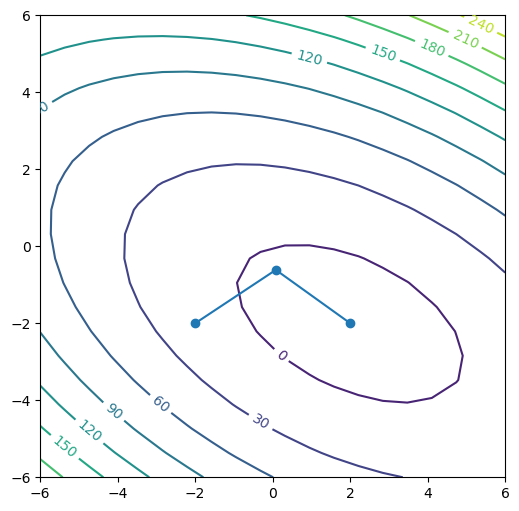

In [31]:
contoursteps(x1, x2, zs, steps)

It works! And did reach the solution in 2 steps!  

If you compare it to the steepest descent you will see that not much has changed, the only conceptually new lines are
```
beta = float(deltanew / deltaold)
d = r + beta * d
```
let's see what they do.

The initialization is very similar, we now have `d` instead of `r` to show the direction of the descent.

In [32]:
x = np.matrix([[-2.0],[-2.0]])
steps = [(-2.0, -2.0)]
i = 0
imax = 10
eps = 0.01
r = b - A * x
d = r
deltanew = (r.T * r)[0,0]
delta0 = deltanew
#while i < imax and deltanew > eps**2 * delta0:

Here we step into the interation of the main loop and it also looks quite familiar. I will not draw the first step since it looks exactly as the first step of the steepest descent. Only starting from the second step we will have a restricting condition: direction of our second step will have to be conjugate to the direction of the first step. But we will worry about that later, right now we boldly make our first step in the direction of the steepest descend.

In [33]:
alpha = deltanew / (d.T * (A * d))[0,0]
x = x + alpha * d
steps.append((x[0, 0], x[1, 0]))

The first step is done and now it is time to figure out the next direction.

In [34]:
r = b - A * x

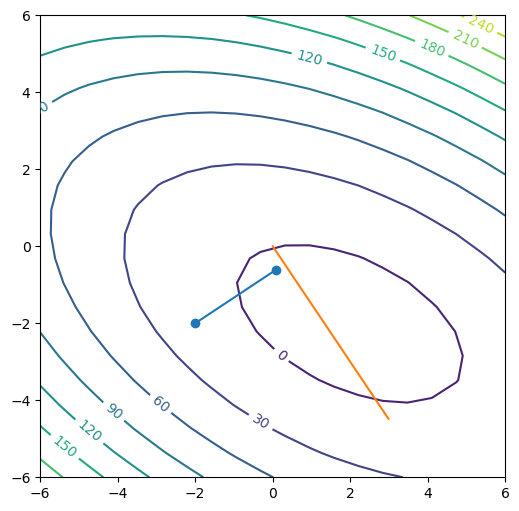

In [35]:
contoursteps(x1, x2, zs, [(-2, -2), (x[0,0],x[1,0])])
plt.plot([0, r[0, 0]], [0, r[1, 0]])
plt.show()

This would be the direction steepest descent would take us, but this time we are bound by the rule that our next step should be A-orthogonal (conjugate) to the first step. And currently

In [36]:
d.T * A * r

matrix([[-167.25333333]])

that is not the case. So here is what we are going to do:

In [37]:
deltaold = deltanew
deltanew = (r.T * r)[0,0]
beta = deltanew / deltaold

this $\beta$ is a new variable, but before going into the details of what it represents let's see what it does:

In [38]:
oldd = d  # this is needed for future demonstration, not relevant to the algorithm
d = r + beta * d

and our new direction now looks like this

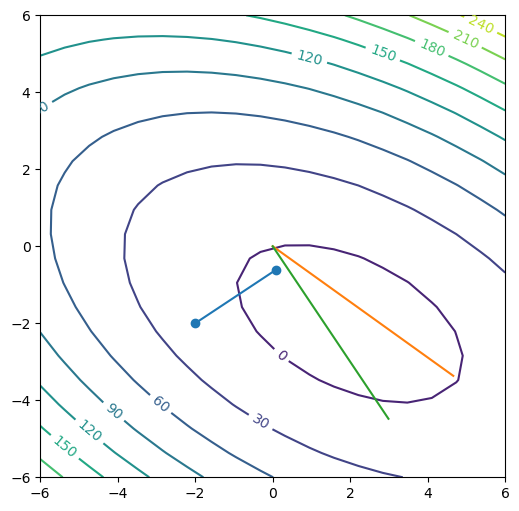

In [39]:
contoursteps(x1, x2, zs, [(-2, -2), (x[0,0],x[1,0])])
plt.plot([0,d[0,0]], [0, d[1,0]])  # new direction
plt.plot([0,r[0,0]], [0, r[1,0]])  # old direction (residual)
plt.show()

and it also satisfies the condition of conjugacy

In [40]:
oldd.T * A * d

matrix([[0.]])

So let us go into math and see how $\beta$ steered us to the conjugate direction.  
The final equation we use to obtain $\beta_{(i)}$ is
$$\beta_{(i)} = \frac{r^\text{T}_{(i)}r_{(i)}}{r^\text{T}_{(i-1)}r_{(i-1)}}$$
now let us see how we get that from Gram-Schmidt process and initial idea of building conjugate directins from the residuals. 

So we have linearly independent vectors $r_{(0)}, \ldots, r_{(n-1)}$ we call *residuals*. And we want to get $d_{(0)}, \ldots, d_{(n-1)}$ conjugate vectors we call *directions*. To construct $d_{(i)}$ we take $r_{(i)}$ and subtract from it non-conjugate components of all previous $d_{(0)}, \ldots, d_{(i-1)}$ vectors (see Figure 24).  

For $d_0$ it is easy: $d_0 = r_0$, and for all the next ones it can be computed as
$$d_{(i)} = r_{(i)} + \displaystyle\sum_{k=0}^{i-1}\beta_{ik}d_{(k)}$$
where $\beta_{ik}$ would indicate how much of each previous direction $d_{(k)}$ should be subtracted ($\beta$ will be a negative coefficient) from $r_{(i)}$
For the particular direction $d_{(i-1)}$ we compute as follows. First we multiply the whole equation by $Ad_{(i-1)}$:
$$d^\text{T}_{(i)}Ad_{(i-1)} = r^\text{T}_{(i)}Ad_{(i-1)} + \displaystyle\sum_{k=0}^{i-1}\beta_{ik}d^\text{T}_{(k)}Ad_{(i-1)}$$
Next we observe that $\forall p \in \{0, \ldots, k-2\}$ we know that $d^\text{T}_{(p)}Ad_{(i-1)} = 0$ because of $A$-orthogonality. So all addends, except for the $d^\text{T}_{(i-1)}Ad_{(i-1)}$ are 0. And the left hand side of the equation we set to 0, because this is what we want to achieve:
$$0 = r^\text{T}_{(i)}Ad_{(i-1)} + \beta_{(i)(i-1)}d^\text{T}_{(i-1)}Ad_{(i-1)}$$
and from that
$$\beta_{(i)(i-1)} = - \frac{r^\text{T}_{(i)}Ad_{(i-1)}}{d^\text{T}_{(i-1)}Ad_{(i-1)}}$$
That is already computable and in our code would look like
```
beta = -float((r.T * A * d) / float(d.T * A * d))
```
but we can simplify it further and avoid doing matrix multiplications.  
Note that (page 6) $r_{(i)} = -Ae_{(i)}$ and from that we can get a recurrence for the residual
$$r_{(i+1)} = -Ae_{(i+1)} = -A(e_{(i)} + \alpha_{(i)}d_{(i)}) = r_{(i)} - \alpha_{(i)}Ad_{(i)}$$
we multiply it by $r_{(i)}$
$$r^\text{T}_{(i)}r_{(i)} = r^\text{T}_{(i)}r_{(i-1)} - \alpha_{(i-1)}r^\text{T}_{(i)}Ad_{(i-1)}$$  
$$\alpha_{(i-1)}r^\text{T}_{(i)}Ad_{(i-1)} = r^\text{T}_{(i)}r_{(i-1)} - r^\text{T}_{(i)}r_{(i)}$$
Since the residuals are othogonal we know $r^\text{T}_{(i)}r_{(i-1)} = 0$ as we can leave it out:
$$r^\text{T}_{(i)}Ad_{(i-1)} = - \frac{1}{\alpha_{(i-1)}}r^\text{T}_{(i)}r_{(i)}$$
Now we take an equation for $\beta_{(i)(i-1)}$ and put it in:
$$\beta_{(i)(i-1)} = \frac{1}{\alpha_{(i-1)}}\frac{r^\text{T}_{(i)}r_{(i)}}{d^\text{T}_{(i-1)}Ad_{(i-1)}}$$
We also had an equation for $\alpha$:
$$\alpha_{(i)} = \frac{d^\text{T}_{(i)}r_{(i)}}{d^\text{T}_{(i)}Ad_{(i)}}$$
We apply it on $i-1$, replace $\alpha_{(i-1)}$ and get
$$\frac{d^\text{T}_{(i-1)}Ad_{(i-1)}}{d^\text{T}_{(i-1)}r_{(i-1)}}\frac{r^\text{T}_{(i)}r_{(i)}}{d^\text{T}_{(i-1)}Ad_{(i-1)}} = \frac{r^\text{T}_{(i)}r_{(i)}}{d^\text{T}_{(i-1)}r_{(i-1)}}$$
The final touch is to use $d^\text{T}_{(i)}r_{(i)} = r^\text{T}_{(i)}r_{(i)}$ (see equatins 40 and 42) we get the desired
$$\beta_{(i)} = \frac{r^\text{T}_{(i)}r_{(i)}}{r^\text{T}_{(i-1)}r_{(i-1)}}$$  

To remind you what it was: $\beta_{(i)}$ shows how much of the direction $d_{(i-1)}$ we should take to keep $d_{(i)}$ $A$-orthogonal (conjugate) to $d_{(i-1)}$.  

Now we increase the iteration counter and continue to the next (in that partiuclar 2D case, final) iteration.

In [41]:
i += 1

where we will decide on how far we should go in this direction and happilty reach the minimum point:

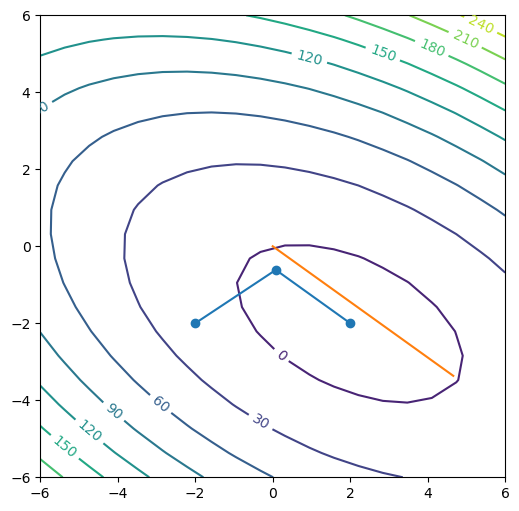

In [42]:
alpha = deltanew / (d.T * (A * d))[0,0]
x = x + alpha * d
steps.append((x[0, 0], x[1, 0]))
contoursteps(x1, x2, zs, steps)
plt.plot([0,d[0,0]], [0, d[1,0]])
plt.show()

All that is fine you say, but looking for a minumum point of a quadratic form isn't what you usually need in practice. Let us look how CG will manage to find a solution on a complex error surface.